In [1]:
import numpy as np
import pandas as pd 
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm_notebook
import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"
train_df = pd.read_csv('../input/train.csv')

In [3]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [4]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [5]:
classifier = Sequential()
classifier.add(Convolution2D(32,3,3, border_mode = 'same',input_shape=(32,32,3), activation = 'relu' ))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 101, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu", padding="same")`
  


In [6]:
classifier.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy', auc ])

Train on 14000 samples, validate on 3500 samples
Epoch 1/100
14000/14000 [==============================] - 2s 160us/step - loss: 0.6056 - acc: 0.6444 - auc: 0.5300 - val_loss: 0.4356 - val_acc: 0.7491 - val_auc: 0.6002
Epoch 2/100
14000/14000 [==============================] - 0s 23us/step - loss: 0.4068 - acc: 0.7468 - auc: 0.6800 - val_loss: 0.2995 - val_acc: 0.7491 - val_auc: 0.7496
Epoch 3/100
14000/14000 [==============================] - 0s 23us/step - loss: 0.3191 - acc: 0.7504 - auc: 0.7962 - val_loss: 0.2803 - val_acc: 0.7491 - val_auc: 0.8309
Epoch 4/100
14000/14000 [==============================] - 0s 22us/step - loss: 0.2781 - acc: 0.7791 - auc: 0.8544 - val_loss: 0.2458 - val_acc: 0.9480 - val_auc: 0.8743
Epoch 5/100
14000/14000 [==============================] - 0s 23us/step - loss: 0.2578 - acc: 0.9391 - auc: 0.8881 - val_loss: 0.2396 - val_acc: 0.9466 - val_auc: 0.8997
Epoch 6/100
14000/14000 [==============================] - 0s 23us/step - loss: 0.2386 - acc: 0.9526

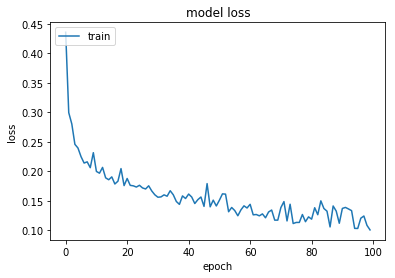

In [7]:
history = classifier.fit(X_tr, Y_tr,
              batch_size=750,
              epochs=100,
              validation_split=0.2,
              shuffle=True)

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255

In [9]:
test_predictions = classifier.predict(X_tst)

In [10]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df["id"] = pd.DataFrame(Test_imgs)
#sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [11]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

In [12]:
sub_df["id"] = pd.DataFrame(Test_imgs)

In [13]:
#for i, img in enumerate(Test_imgs):
    #sub_df.set_value(i,'id',img)
#sub_df['id'] = Test_imgs
sub_df

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1.000000
1,da498fc860c8b76ca925c4218c5f0373.jpg,1.000000
2,433052030eeb117e4bd8f6ce033c9da4.jpg,0.198464
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0.181997
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,1.000000
5,873191a1575a6292ed92714bfc659b87.jpg,1.000000
6,8f99b87b7a652d68232fbd6379529368.jpg,1.000000
7,316e46903ee485aeecfd229973abcc71.jpg,0.181997
8,fc76ae520f30c6aba6dbfa8e82def89c.jpg,1.000000
9,ee3ddba5f04e0674db0d18a9dd3b8131.jpg,0.181997


In [14]:
sub_df.to_csv('submission.csv',index=False)

In [15]:
sub_df.head()

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1.000000
1,da498fc860c8b76ca925c4218c5f0373.jpg,1.000000
2,433052030eeb117e4bd8f6ce033c9da4.jpg,0.198464
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0.181997
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,1.000000
